In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from scipy import signal
from scipy.optimize import curve_fit
from scipy import stats
from numpy.polynomial.polynomial import polyval

%matplotlib inline
plt.style.use('seaborn')

## Functions

These functions are used to do the fitting of the wavelengths from the soil spectra measured with the NIRone spectrometer.  The parameters and form of the equation were modeled by David using Igor Pro.

The functions presuppose that the parameters for the equation are in np.arrays.  In the functions that follow, the fixed parameters are read from .csv to  variable `fixed_params`, which the functions depend on being in memory.  I did that to make it easier to change the functions later.  Eventually this should be changed so that the functions run independently.

In this version I have split up the `model_fit()` function to only do the model fitting. New functions are included to create the `farray`, `f_sd_err`, and `high_f1` arrays.

In [2]:
def poly4(x, x0, p):
    '''
    calculates the polynomial portion of the spectral fits.
    x is the input data.    
    x0 is the x offset.
    p is an np.array containing c0, c1, c2, c3, and c4, in that order.
    '''
    w = x - x0
    return p[0] + (p[1] * w) + (p[2] * w**2) + (p[3] * w ** 3) + (p[4] * w ** 4)

def gauss_peak(x, p):
    '''
    Calculates the Gaussian peak portion of the spectral fits.
    x is the input data.
    p is np.array containing y0, A, x0, and width, in that order.
    '''
    return p[0] + p[1] * np.exp(-(((x - p[2])/p[3])**2))

def w_calc(x, p1, p2, w):
    '''
    Calculates the water peak (either w1 or w2) portions of the spectral fits.
    x is the input data.    
    p1 and p2 are np.arrays containing the y offset, amplitude, x offset, and width.
    w is the multiplier w1 or w2.
    '''
    peak1 = gauss_peak(x, p1)
    peak2 = gauss_peak(x, p2)
    return w * (peak1 + peak2)

def m_calc(x, p1, m):
    '''
    Calculates the m1 portion of the spectral fits.
    x is the input data
    p1 is an np.array containing the y offset, amplitude, x offset, and width.
    m is the multiplier m1.
    '''
    return m * gauss_peak(x, p1)


def f_calc(x, p1, p2, p3, f):
    '''
    Calculates the f1 portion of the spectral fits.
    x is the input data.
    p1, p2, and p3 are np.arrays containing the y offset, amplitude, x offset, and width.
    f is the multiplier f1.
    '''
    peak1 = gauss_peak(x, p1)
    peak2 = gauss_peak(x, p2)
    peak3 = gauss_peak(x, p3)
    return f * (peak1 + peak2 + peak3)

def spec_calc(x, mp, fp):
    '''
    Calculates and sums the sub-portions of the spectral fits.
    x is the input data.
    mp is an np.array containing the modeled parameters (c0 through f1).
    fp is an np.array containing the fixed parameters from the fit equation.
    '''
    cp = mp[0:5]
    c = poly4(x, fp[0], cp)
    w1p = mp[5]
    w1 = w_calc(x, fp[1:5], fp[5:9], w1p)
    w2p = mp[6]
    w2 = w_calc(x, fp[9:13], fp[13:17], w2p)
    m1p = mp[7]
    m1 = m_calc(x, fp[17:21], m1p)
    f1p = mp[8]
    f1 = f_calc(x, fp[21:25], fp[25:29], fp[29:], f1p)
    return c + w1 + w2 + m1 + f1

def spec_fit(x, c0, c1, c2, c3, c4, w1, w2, m1, f1):
    '''
    This is used as the function in the curve fit process.
    Note that this presupposes the fixed parameter data frame, which must be 
    named fixed_params and must already exist before this can be run.
    '''
    fp = fixed_params
    mp = np.array([c0, c1, c2, c3, c4, w1, w2, m1, f1])
    return spec_calc(x, mp, fp)

def model_fit(df, wave_array):
    '''
    Performs spec_fit function on the input spectra.
    
    Input parameters:
    df is dataframe containing only the spectra, without extraneous columns
    wave_array is np.array containing the wavelengths of spectra
    
    Return values:
    modelparams is np.array of parameters output from curve_fit
    modelcovar is np.array of covariance array output from curve_fit
    modeled_spectra is np.array of the modeled spectra using the curve_fit parameters
    residual_spectra is np.array of the original spectrum - the modeled spectrum
    
    '''
    number = df.shape[0]
    modelparams = np.empty((number, 9), dtype = float)
    modelcovar = np.empty((number, 9, 9), dtype = float)
    modeled_spectra = np.empty((number,wave_array.shape[0]), dtype = float)
    residual_spectra = np.empty((number, wave_array.shape[0]), dtype = float)
    for i in range(number):
        row = df.iloc[i, :]
        modeled, pcov = curve_fit(spec_fit, wave_array, row)
        modelparams[i, :] = modeled
        modelcovar[i, ::] = pcov
        modeled_spectra[i, :] = spec_calc(wave_array, modeled, fixed_params)
        residual_spectra[i, :] = row - modeled_spectra[i, :]
    return modelparams, modelcovar, modeled_spectra, residual_spectra

def extract_farray(modelparams):
    '''
    Convenience function to create an np.array containing only the f1 values
    
    Input:  the modelparams np.array created by model_fit().
    '''
    return modelparams[:, 8]

def extract_f_sd_err(modelcovar):
    '''
    Convenience function to create an np.array containing the standard deviation
       of the covariance matrix for the f1 term.
       
    Input:  the modelcovar np.array created by model_fit().
   
    '''
    f_sd_err = np.empty(modelcovar.shape[0])
    for i in range(modelcovar.shape[0]):
        f_sd_err[i] = np.diag(modelcovar[i, :, :])[8]
    return f_sd_err

def high_f1_numbers(farray, threshold):
    '''
    Returns np.array of the index positions of spectra with f1 values greater than the
       threshold.  Use this with iloc to find the appropriate rows in the dataframe.
       
    Input:  np.array output from extract_farray() and desired threshold value.
    '''
    return np.where(farray > threshold)[0]
    



## Read the parameters and data from csv files.

Also establish some wavelength value arrays.

In [101]:
model_param_df = pd.read_csv('Fit function data.csv', index_col = 'spectrum')
fixed_params = np.loadtxt('fit_function_equation_parameters.csv', delimiter = ',')
nirone = pd.read_csv('NIRONE_TEST.csv', index_col = 'name')
nir_waves = np.arange(1550, 1955, 5)
spec_csv = 'lucas_spec_smaller.csv'
spec = pd.read_csv(spec_csv)
lucas_nir = spec.loc[:, 'spc.1550':'spc.1950']
lucas_waves = np.arange(1550.0, 1950.5, 0.5)
waves_17_18 = np.arange(1700.0, 1800.5, 0.5)
waves_19_1950 = np.arange(1900.0, 1950.5, 0.5)

## Apply the fit function to LUCAS spectra

First I run `model_fit()` to fit the spectra.
From that output I determine the `farray` and `high_f1`.  I am using 0.006 as the threshold for a high fatty acid peak value for now.

In [4]:
modelparams, modelcovar, modeled_spectra, residual_spectra = model_fit(lucas_nir, lucas_waves)

In [5]:
farray = extract_farray(modelparams)

In [6]:
high_f1 = high_f1_numbers(farray, 0.006)

In [7]:
lucas_nir.iloc[high_f1, 0:4]

,spc.1550,spc.1550.5,spc.1551,spc.1551.5
3149,0.303594,0.303310,0.303028,0.302748
3182,0.282933,0.282546,0.282162,0.281782
3185,0.273899,0.273717,0.273536,0.273357
3193,0.321418,0.321123,0.320830,0.320541
3201,0.347535,0.347246,0.346960,0.346677
...,...,...,...,...
17231,0.385157,0.385060,0.384965,0.384870
18498,0.206601,0.206129,0.205660,0.205197
18516,0.251501,0.251084,0.250671,0.250261
18539,0.212437,0.212078,0.211722,0.211370


In [8]:
modeled_spectra[high_f1].shape

(180, 801)

## Visualize the distribution of the f1 values

In [9]:
f_series = pd.Series(farray)

In [10]:
f_series.describe()

count    19010.000000
mean        -0.000227
std          0.002113
min         -0.007549
25%         -0.001058
50%         -0.000314
75%          0.000344
max          0.059853
dtype: float64

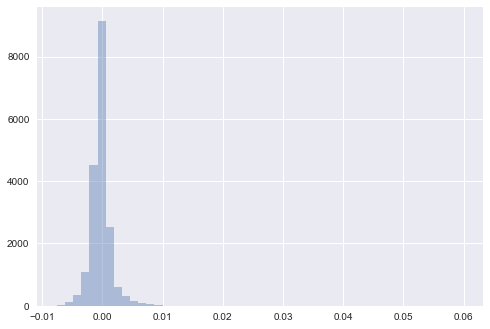

In [11]:
sns.distplot(farray, kde = False);

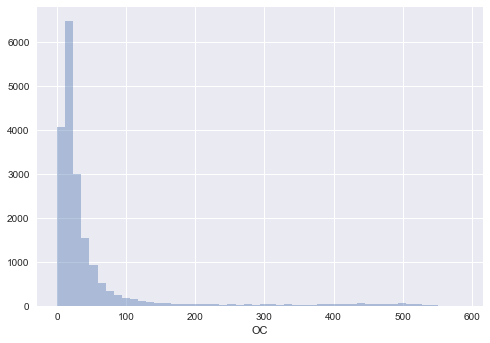

In [12]:
sns.distplot(spec['OC'], kde = False);

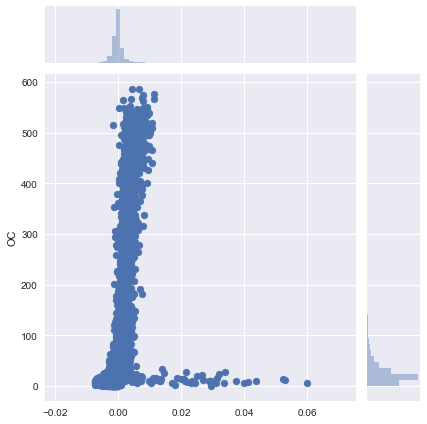

In [13]:
sns.jointplot(x = farray, y = spec['OC']);

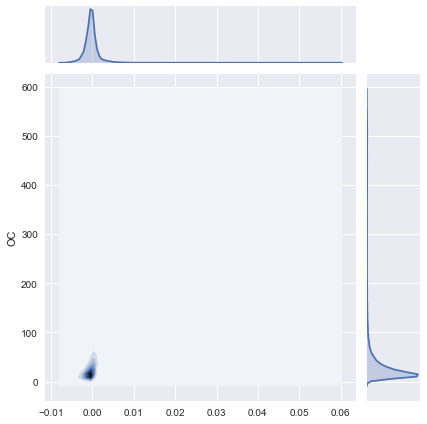

In [14]:
sns.jointplot(x = farray, y = spec['OC'], kind = 'kde');

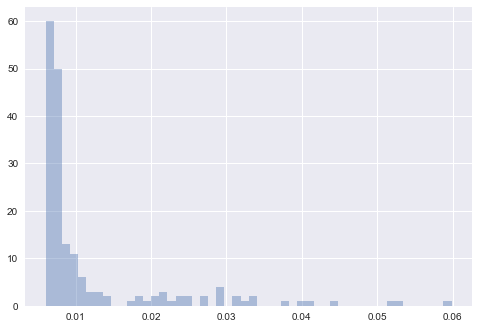

In [15]:
sns.distplot(farray[high_f1], kde = False, bins = 50);

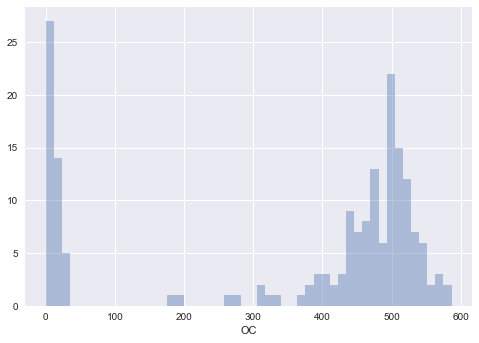

In [16]:
oc = spec.columns.get_loc('OC')
sns.distplot(spec.iloc[high_f1, oc], kde = False, bins = 50);

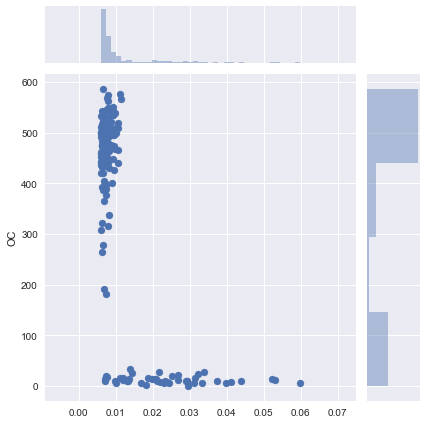

In [17]:
sns.jointplot(x = farray[high_f1], y = spec.iloc[high_f1, oc]);

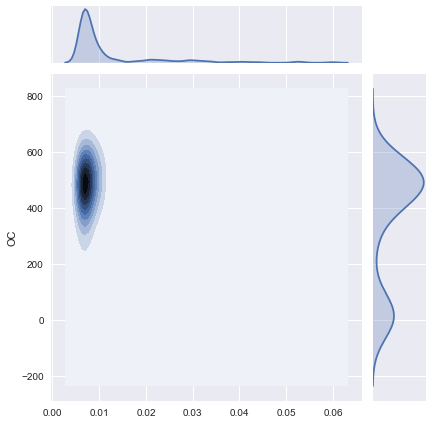

In [18]:
sns.jointplot(x = farray[high_f1], y = spec.iloc[high_f1, oc], kind = 'kde');

In [19]:
lowOC_highf1 = spec.loc[(spec['OC'] < 50) & (farray > 0.002)]

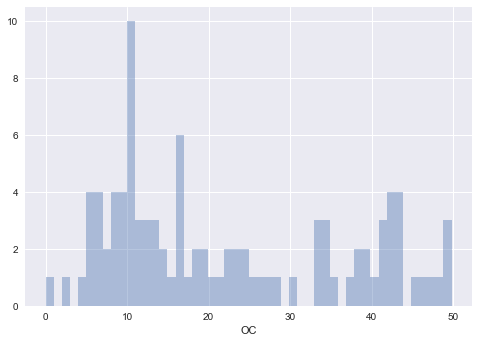

In [20]:
sns.distplot(lowOC_highf1['OC'], kde = False, bins = 50)

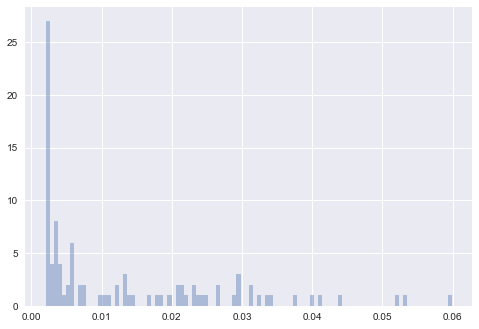

In [21]:
sns.distplot(farray[(spec['OC'] < 50) & (farray > 0.002)], kde = False, bins = 100)

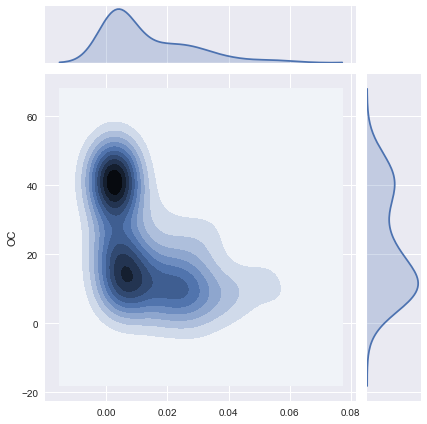

In [22]:
sns.jointplot(x = farray[(spec['OC'] < 50) & (farray > 0.002)], y = lowOC_highf1['OC'], kind = 'kde');

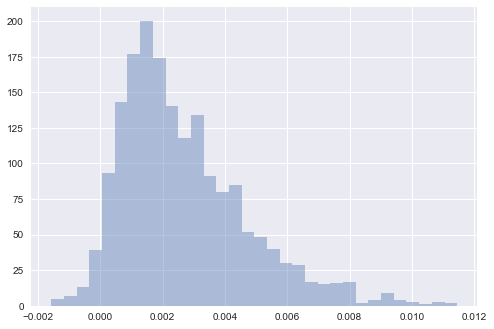

In [23]:
sns.distplot(farray[spec['OC']> 100], kde = False)

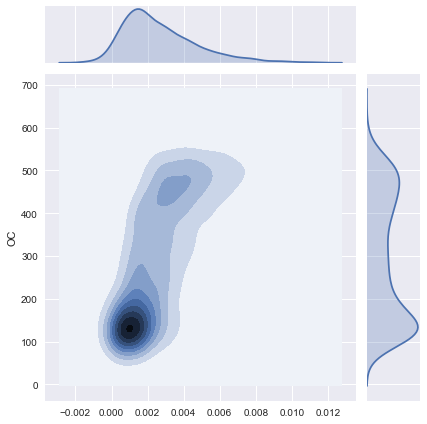

In [24]:
sns.jointplot(x = farray[spec['OC']> 100], y = spec.loc[spec['OC'] > 100]['OC'], kind = 'kde');

## Find spectra to use as examples

First I wanted to find an example of a spectrum which has a negative f1 value.  I therefore looked for the spectrum with the smallest f1 value.  Needed to take the first of the array because I needed it as a float, not as an array.

The spectrum chosen was number 12094.

In [35]:
min_loc = f_series.loc[f_series == f_series.min()].index.values[0]

In [60]:
f1_min_spec = lucas_nir.loc[lucas_nir.index == min_loc]
f1_min_modeled = modeled_spectra[min_loc]
spc1700 = lucas_nir.columns.get_loc('spc.1700')
spc1800 = lucas_nir.columns.get_loc('spc.1800')
spc1900 = lucas_nir.columns.get_loc('spc.1900')
spc1950 = lucas_nir.columns.get_loc('spc.1950')

Plot of spectrum 12094.

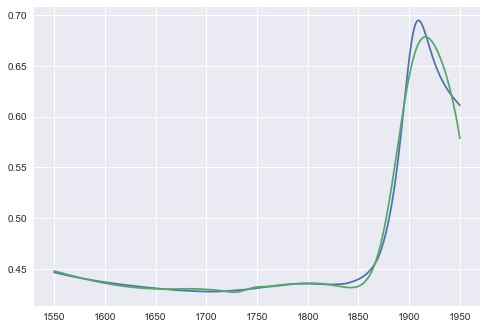

In [174]:
plt.plot(lucas_waves, f1_min_spec.iloc[0, :])
plt.plot(lucas_waves, f1_min_modeled);

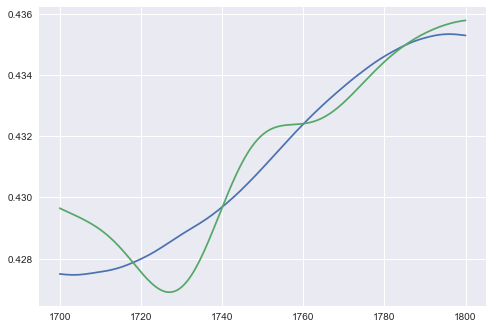

In [173]:

plt.plot(waves_17_18, f1_min_spec.loc[min_loc, 'spc.1700':'spc.1800'])
plt.plot(waves_17_18, f1_min_modeled[spc1700:spc1800+1]);

In [58]:
example_spec_list = [min_loc]

In [59]:
example_spec_list

[12094]

## Next spectrum

Here I wanted to find spectra that the model didn't work well in the water region, so I looked for spectra that had large residuals between 1900 and 1950 nm.

In [75]:
spc1900_1950_col_names = lucas_nir.loc[:, 'spc.1900':'spc.1950'].columns.values
spec_rows = spec.index.values
water_resid = pd.DataFrame(residual_spectra[:, spc1900:spc1950+1], index = spec_rows, columns = spc1900_1950_col_names)

In [76]:
water_resid.shape

(19010, 101)

In [77]:
water_resid.max(axis = 1).shape

(19010,)

This shows the distribution of the largest residual for each spectrum between 1900 and 1950.

In [78]:
water_resid_max = water_resid.max(axis = 1)

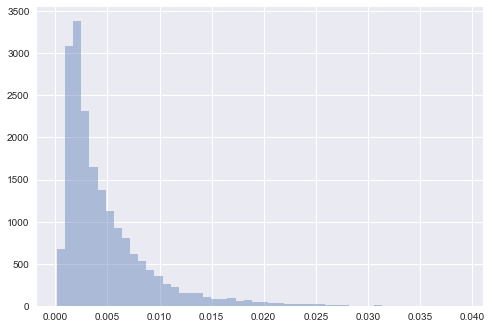

In [79]:
sns.distplot(water_resid_max, kde = False);

In most cases, the position of the largest residual in the spectrum was at 1950 nm.  

In [81]:
water_resid.idxmax(axis = 1)

0        spc.1950
1        spc.1950
2        spc.1950
3        spc.1950
4        spc.1950
           ...   
19005    spc.1950
19006    spc.1950
19007    spc.1950
19008    spc.1950
19009    spc.1950
Length: 19010, dtype: object

In [82]:
water_resid_array = residual_spectra[:, spc1900:spc1950+1]

In [87]:
water_resid_position = np.argmax(water_resid_array, axis = 1)

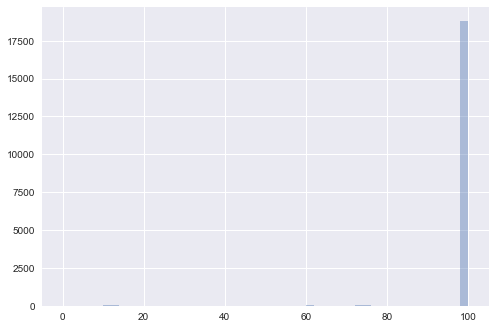

In [175]:
sns.distplot(water_resid_position, kde = False);

In [89]:
water_resid_position[water_resid_position != 100]

array([22, 23, 60, 64, 59, 60, 61, 11, 63, 11, 23, 17, 76, 21, 20, 12, 14,
       13, 59, 22, 59, 20, 20, 24, 16, 12, 22, 10, 14, 61, 14, 11, 10, 74,
        8, 73, 73, 73, 12, 14, 13, 77,  8, 74, 11, 11, 75, 15, 74, 73, 73,
       73, 13, 73, 73, 77, 72, 72, 73, 74, 74, 75, 73, 73, 74, 73, 11,  9,
       75, 14, 12, 60, 73, 60, 13, 76, 73, 75, 76, 13, 11, 75, 12, 12, 13,
       73, 15, 12, 10, 74, 78, 73, 15, 74, 12, 74, 73, 74, 73, 75, 77, 76,
       10, 17, 75, 13, 14, 10, 12, 16, 60, 70, 19, 23, 72, 72, 74, 17, 22,
       60, 60,  0, 59, 60, 61, 60, 60, 23,  2, 60, 60, 60, 60, 60, 60, 60,
       17, 20, 18, 17, 12, 14, 20, 19, 19, 17, 61, 11, 22, 20, 16, 75, 13,
       74, 12, 19, 14, 13, 12, 19,  8,  7, 23, 20, 15, 11, 12, 12, 13, 66,
       13, 13, 62, 17, 14, 60, 59, 16, 66, 12, 14, 62, 10, 11, 60, 60, 20,
       59, 58, 61, 59, 60, 59,  4, 58, 13, 18, 13, 22, 14, 22, 14, 61, 11,
       73, 74, 75, 10, 11, 11, 22, 12])

This shows the distribution (by column beyond 1900 nm) of the maximum residual for those spectra where the position was not 1950 nm.

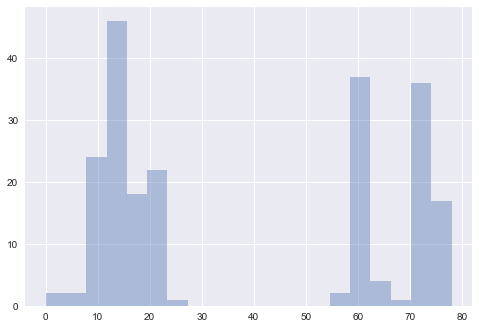

In [176]:
sns.distplot(water_resid_position[water_resid_position != 100], kde = False, bins = 20);

In [98]:
water_resid.idxmax()

spc.1900      4200
spc.1900.5    4200
spc.1901      4200
spc.1901.5    4200
spc.1902      4200
              ... 
spc.1948      4148
spc.1948.5    4148
spc.1949      4148
spc.1949.5    4148
spc.1950      4148
Length: 101, dtype: int64

In [97]:
water_resid.loc[water_resid['spc.1900'] == water_resid.max().max()]

,spc.1900,spc.1900.5,spc.1901,spc.1901.5,spc.1902,spc.1902.5,spc.1903,spc.1903.5,spc.1904,spc.1904.5,...,spc.1945.5,spc.1946,spc.1946.5,spc.1947,spc.1947.5,spc.1948,spc.1948.5,spc.1949,spc.1949.5,spc.1950


Spectrum 4148 is one I had identified earlier as not fitting well in the water peak region.

In [99]:
water_resid.loc[4148, :]

spc.1900      0.017978
spc.1900.5    0.019596
spc.1901      0.021121
spc.1901.5    0.022537
spc.1902      0.023832
                ...   
spc.1948      0.027338
spc.1948.5    0.030157
spc.1949      0.033058
spc.1949.5    0.036038
spc.1950      0.039098
Name: 4148, Length: 101, dtype: float64

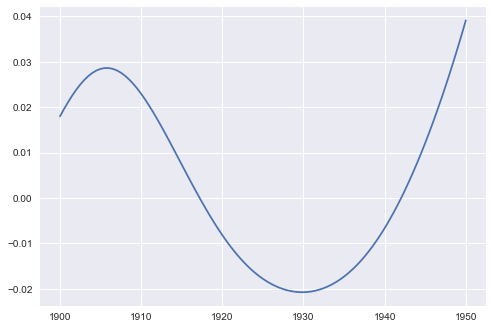

In [102]:
plt.plot(waves_19_1950, water_resid.loc[4148, :])

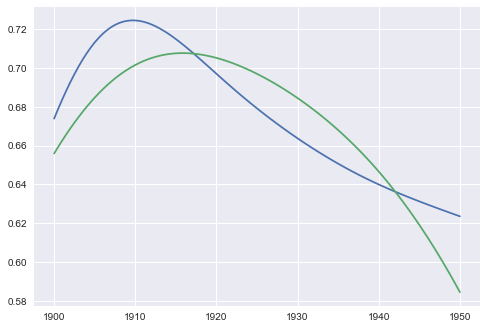

In [105]:
plt.plot(waves_19_1950,lucas_nir.loc[4148, 'spc.1900':'spc.1950'])
plt.plot(waves_19_1950, modeled_spectra[4148, spc1900:spc1950+1])

In [106]:
example_spec_list.append(4148)

## Export spectra 12094 and 4148



Here I export spectra 12094 and 4148 to a csv.

In [177]:
example_spec_list

[12094, 4148]

In [109]:
example_spec = lucas_nir.loc[example_spec_list, :]
example_spec

,spc.1550,spc.1550.5,spc.1551,spc.1551.5,spc.1552,spc.1552.5,spc.1553,spc.1553.5,spc.1554,spc.1554.5,...,spc.1945.5,spc.1946,spc.1946.5,spc.1947,spc.1947.5,spc.1948,spc.1948.5,spc.1949,spc.1949.5,spc.1950
12094,0.446533,0.446408,0.446284,0.446161,0.446040,0.445918,0.445798,0.445678,0.445559,0.445440,...,0.616149,0.615556,0.614967,0.614383,0.613804,0.613228,0.612657,0.612088,0.611522,0.610958
4148,0.339498,0.339239,0.338982,0.338727,0.338474,0.338222,0.337974,0.337727,0.337482,0.337238,...,0.630459,0.629667,0.628883,0.628107,0.627337,0.626574,0.625815,0.625062,0.624313,0.623568


In [111]:
example_spec.T.to_csv('example_spec.csv', header = False, index = False)

## Spectrum 3984

Here I decided to look for the spectrum with the largest f1 value, because it had not peaked at the one of our fatty acid peak wavelengths.  I therefore identifed spectrum **3984**.

In [112]:
max_loc = f_series.loc[f_series == f_series.max()].index.values[0]
f1_max_spec = lucas_nir.loc[lucas_nir.index == max_loc]
f1_max_modeled = modeled_spectra[max_loc]

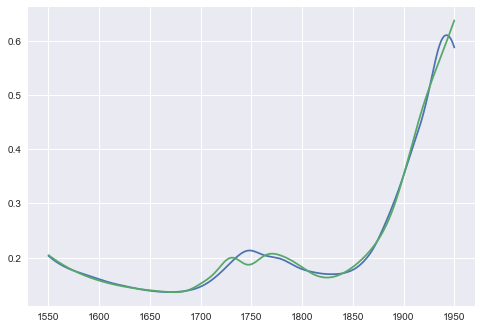

In [178]:
plt.plot(lucas_waves, f1_max_spec.iloc[0, :])
plt.plot(lucas_waves, f1_max_modeled);

In [114]:
max_loc

3984

In [119]:
lucas_nir.loc[max_loc, :]

spc.1550      0.203304
spc.1550.5    0.202533
spc.1551      0.201766
spc.1551.5    0.201003
spc.1552      0.200246
                ...   
spc.1948      0.598152
spc.1948.5    0.595846
spc.1949      0.593334
spc.1949.5    0.590618
spc.1950      0.587704
Name: 3984, Length: 801, dtype: float64

Here I export number 3984.

In [120]:
f1_max_spec.T.to_csv('lucas3984.csv', header = False, index = False)

## Spectrum 1088

Here I exported the first spectrum in the list of all spectra with OC > 500 g/kg.

In [179]:
lucas_nir.loc[spec['OC'] > 500].iloc[0, :]

spc.1550      0.410250
spc.1550.5    0.410187
spc.1551      0.410124
spc.1551.5    0.410061
spc.1552      0.409998
                ...   
spc.1948      0.493976
spc.1948.5    0.493470
spc.1949      0.492965
spc.1949.5    0.492460
spc.1950      0.491953
Name: 1088, Length: 801, dtype: float64

In [ ]:
lucas_nir.loc[spec['OC'] > 500].iloc[0, :].T.to_csv('lucas1088.csv', header = False, index = False)

## Very high OC,  f1 peak less than 1730 nm

Here I wanted to find spectra that had a 1700-1800 nm peak of less than 1730 and a high OC content.  I started by creating a dataframe that had the maximum values and the wavelength of the maximum values, as well as the OC content for all of the spectra.

In [141]:
oc_content = spec.columns.get_loc('OC')
sspc1700 = spec.columns.get_loc('spc.1700')
sspc1800 = spec.columns.get_loc('spc.1800')
maxvals2 = np.empty(spec.shape[0], dtype = float)
maxwaves2 = np.empty(spec.shape[0], dtype = float)
oc2 = np.empty(spec.shape[0], dtype = float)
for i in range(spec.shape[0]):
    series2 = spec.iloc[i, sspc1700:sspc1800]
    maxval2 = series2.max()
    maxstring2 = series2[series2 == maxval2].index.tolist()[0]
    maxwave2 = float(maxstring2[4:])
    maxvals2[i] = maxval2
    maxwaves2[i]= maxwave2
    oc2[i] = (spec.iloc[i, oc_content])

In [142]:
vw = pd.DataFrame()

In [143]:
vw

""


In [154]:
vw2 = vw.assign(maxval = pd.Series(maxvals2))

In [155]:
vw2

,maxval
0,0.421552
1,0.358430
2,0.369539
3,0.418863
4,0.437625
...,...
19005,0.435611
19006,0.449001
19007,0.318476
19008,0.529241


In [157]:
vw2 = vw2.assign(maxwave = pd.Series(maxwaves2))

In [158]:
vw2

,maxval,maxwave
0,0.421552,1794.5
1,0.358430,1776.0
2,0.369539,1766.5
3,0.418863,1760.5
4,0.437625,1776.5
...,...,...
19005,0.435611,1765.0
19006,0.449001,1700.0
19007,0.318476,1700.0
19008,0.529241,1728.5


In [159]:
vw2 = vw2.assign(oc = pd.Series(oc2))

In [160]:
vw2

,maxval,maxwave,oc
0,0.421552,1794.5,27.3
1,0.358430,1776.0,15.3
2,0.369539,1766.5,42.4
3,0.418863,1760.5,42.6
4,0.437625,1776.5,35.7
...,...,...,...
19005,0.435611,1765.0,22.2
19006,0.449001,1700.0,34.1
19007,0.318476,1700.0,15.3
19008,0.529241,1728.5,55.4


## Spectrum 6408

Spectrum 6408 had both a wavelength for the maximum value of less than 1730 and a very high OC content.  Of the two meeting those criteria, **6408** had the highest f1 parameter, so I chose it.

In [162]:
vw2.loc[(vw2['maxwave'] < 1730) & (vw2['oc']> 580) ]

,maxval,maxwave,oc
6037,0.516026,1727.0,586.4
6408,0.440329,1728.0,586.8


In [163]:
farray[6037]

0.004239163105088688

In [164]:
farray[6408]

0.006496172223578858

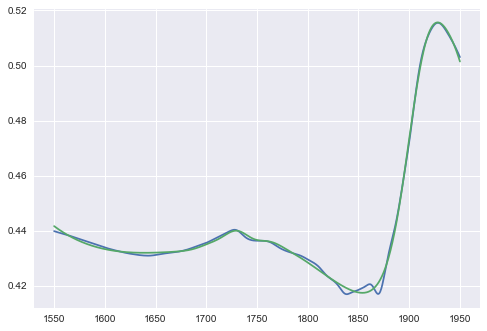

In [165]:
plt.plot(lucas_waves, lucas_nir.iloc[6408, :])
plt.plot(lucas_waves, modeled_spectra[6408, :])

## Spectrum 17095

Here I chose one spectrum, **17095** out of those that had a peak in a wavelength longer than 1760, and a high OC content, and a large f1 vale.

In [168]:
vw2.loc[(vw2['maxwave'] > 1760) & (vw2['oc']> 400) & (farray > 0.006) ]

,maxval,maxwave,oc
16003,0.289159,1762.5,421.4
16138,0.308710,1764.5,475.1
16478,0.305595,1763.0,498.5
17006,0.269383,1765.0,491.6
17095,0.275742,1763.0,474.2


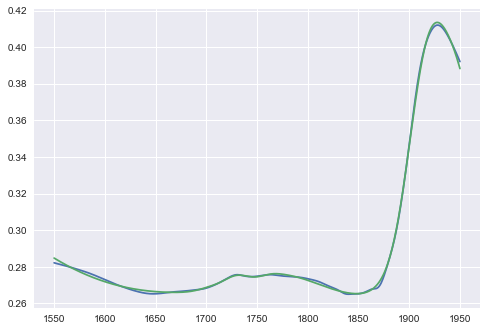

In [170]:
plt.plot(lucas_waves, lucas_nir.iloc[17095, :])
plt.plot(lucas_waves, modeled_spectra[17095, :])

In [171]:
lucas_nir.loc[6408, :].T.to_csv('lucas6408.csv', header = False, index = False)

In [172]:
lucas_nir.loc[17095, :].T.to_csv('lucas17095.csv', header = False, index = False)